In [12]:
# Graficos y visualizaciones
import matplotlib.pyplot as plt

# Liberias para manejo de datos
import pandas as pd

# Liberias estandar
import time
import os

In [13]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/NewTesis'

In [14]:
"""
Metodos para realizar las estadisticas de los datos de precipitacion
"""

'\nMetodos para realizar las estadisticas de los datos de precipitacion\n'

In [15]:
#Realiza un grafico de dispersion (Tipo = 1) o boxplit (Tipo = 2)
def Grafico(df,filename,tipo):    
    x = df.index
    y = df['dato']   
    
    if tipo==1:
        plt.clf()
        plt.scatter(x=x,y=y, alpha=0.1)
    if tipo==2:
        plt.clf()
        plt.boxplot(x=y)
        
    plt.xlabel("Indices")
    plt.ylabel("Precipitacion (mm/h)")
    plt.title(f"{filename.split('/')[-1][:-4]}")
    plt.axhline(y=y.quantile(0.99), color='r', linestyle='-')
    
    plt.savefig(filename)
    plt.clf()
    #plt.show()

    return True

In [16]:
# Crea una carpeta en path
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT       
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [17]:
#Por cada estacion se hallara:
#- Cantidad de datos,- Promedio,- Varianza,- Valor min ,- Valor max
#- Fecha minima,- Fecha Maxima,- Cantidad de datos atipicos (Mayores a 99%)
#- Cantidad de NA,- Cantidad de ceros

#Graficos
#- Boxplot,- Dispersion
def resumenStats(path_base,estacionesF,datosF,year,grafico=0, listDir=''):
    
    
    stations = pd.read_csv(estacionesF)
    
    if listDir:
        listDF = []
        for file in listDir:
            listDF.append(pd.read_csv(file,encoding='latin-1'))
        datos = pd.concat(listDF, ignore_index=True)           
        
    else:
        datos = pd.read_csv(datosF,encoding='latin-1')    
        
    start_time = time.time() 
    resultado = []
    
    #Auxiliares    
    total = len(stations.index)
    completados = 1 
    
    path_plot = crearDir(f'{path_base}/Archivos/Reportes/Plots/', year)

    #Por cada estacion se realizara lso graficos
    for i in stations.index:    
        station = stations['ESTACION'][i]
        code = stations['CODE'][i]
        LON = stations['LON'][i]
        LAT = stations['LAT'][i]
        ALT = stations['ALT'][i]

        tempDato = datos.loc[datos['NOMBRE']==station]    
        cantNA = tempDato.loc[tempDato['PRECIPITACION'].isna()].count()[0]

        #Eliminamos todos los NA antes de realizar las estadisticas        
        tempDato = tempDato.dropna(axis='index',subset=['PRECIPITACION'])   
        
        
        cantC02 = tempDato.loc[tempDato['FLAG'].isin(['C0000002'])].count()[0]
        cantC01 = tempDato.loc[tempDato['FLAG'].isin(['C0000001'])].count()[0] 
        cantM01 = tempDato.loc[tempDato['FLAG'].isin(['M0000001','M0000001, M0110302','M0110302'])].count()[0]
        cantM02 = tempDato.loc[tempDato['FLAG'].isin(['M0000002','DIM00001'])].count()[0]
        cantD01 = tempDato.loc[tempDato['FLAG'].isin(['D0220301','D0230301','D0230303'])].count()[0]
        
        #Eliminamos los valores valores mayor a 1k o menor a 1k
        tempDato = tempDato[tempDato['PRECIPITACION']<=400]
        tempDato = tempDato[tempDato['PRECIPITACION']>=0]
    
        

        stats = tempDato['PRECIPITACION'].describe()
        stats = stats.to_dict()    
        fmin = tempDato['FECHA'].min()
        fmax = tempDato['FECHA'].max()    
        stats['FechaMax'] = fmax
        stats['count'] = int(stats['count'])
        stats['FechaMin'] = fmin    
        stats['Nombre'] = station
        stats['Codigo'] = code
        stats['ceros'] = tempDato.loc[tempDato['PRECIPITACION']==0].count()[0]
        stats['NA'] = cantNA
        
        stats['cantC02'] = cantC02
        stats['cantC01'] = cantC01
        stats['cantM01'] = cantM01
        stats['cantM02'] = cantM02
        stats['cantD01'] = cantD01
        
        stats['75mayor'] = tempDato.loc[tempDato['PRECIPITACION']>stats['75%']].count()[0]
        stats['90mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.90)].count()[0]
        stats['90%'] =  tempDato['PRECIPITACION'].quantile(0.90)
        stats['99mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.99)].count()[0]
        stats['99%'] =  tempDato['PRECIPITACION'].quantile(0.99)
        stats['LON'] = LON
        stats['LAT'] = LAT
        stats['ALT'] = ALT
        resultado.append(stats)
        
        if grafico:
            Grafico(tempDato,f'{path_plot}/{code}_scatter.png',1)   
            Grafico(tempDato,f'{path_plot}/{code}_box.png',2)   
        
        completados = completados +1
        if not completados % 50:
            progreso = completados/total*100
            f = '{0:.3g}'.format(progreso)
            print(f"Procesando - {f}%")
            

    print("Time taken: %.2fs" % (time.time() - start_time)) 
    
    #Borramos las estaciones que no tengan datos
    df = pd.DataFrame(resultado)
    df = df[df['count']!=0]

    #Guardamso las estadisticas
    df = df.astype({"count":int})
    df.to_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_{year}.csv',index=False)

    return resultado


In [18]:
# Lista de los flags en orden de fase
listaFases = [
    'ND',    'C0000001',    'M0000001',    'M0000001, M0110302' ,    'M0110302',
    'D0210301',    'D0210302',    'D0210303',    'D0210304',    'D0220301',
    'D0230301',    'D0230302',    'D0230303',    'D0230304',    'C0000002',
    'DIM00001',    'M0000002'
]
dfFases = pd.DataFrame({'FLAG' : listaFases})
dfFases = dfFases.reset_index().set_index('FLAG')

In [19]:
"""
Realizamos las metricas por estacionara cada archivo (año)
"""

'\nRealizamos las metricas por estacionara cada archivo (año)\n'

In [20]:
# Nombre de los archivos
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'

listDir = [Fdatos2020,Fdatos2021]
# Eliminar malos en Etapa 1 ( orden de "listaFases")
eliminarFG = [0,1,2,15,6,7,8,9,10,11,12,13]#,2,3,4]

In [21]:
#Revisamos la cantidad de datos por flag
#Año 2020
dfFlags20 = pd.read_csv(Fdatos2020,encoding='latin-1')
flagsDF20 = dfFlags20.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
flagsDF20['Fase'] = flagsDF20['FLAG'].map(dfFases['index'])
flagsDF20 = flagsDF20.sort_values(by=['Fase'])

#Quitamos los flag 'M...' y 'ND'
noND20 = flagsDF20[~flagsDF20['Fase'].isin(eliminarFG)]
noND20


,FLAG,Cantidad,Fase
7,"M0000001, M0110302",1778,3
9,M0110302,131,4
1,C0000002,4588,14
8,M0000002,133,16


In [11]:
#Revisamos la cantidad de datos por flag
#Año 2021
valores2021 = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/SENAMHI/Datasets/REPORTE_SGD_2021.csv'
dfFlags21 = pd.read_csv(Fdatos2021,encoding='latin-1')
flagsDF21 = dfFlags21.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
flagsDF21['Fase'] = flagsDF21['FLAG'].map(dfFases['index'])
flagsDF21 = flagsDF21.sort_values(by=['Fase'])

#Quitamos los flag 'M...' y 'ND'
noND21 = flagsDF21[~flagsDF21['Fase'].isin(eliminarFG)]
noND21

,FLAG,Cantidad,Fase
6,"M0000001, M0110302",3868,3
8,M0110302,423,4
1,C0000002,53776,14
7,M0000002,8414,16


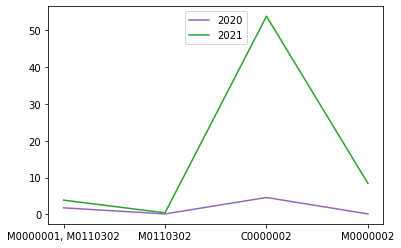

In [12]:
#Graficamos los FLAGS
ejeX = dfFases[~dfFases['index'].isin(eliminarFG)]

ejeY = ejeX.merge(noND20, on='FLAG', how='left')
ejeY = ejeY.merge(noND21, on='FLAG',suffixes=('_20', '_21'))


fig, ax = plt.subplots()

ax.plot(ejeY['FLAG'], ejeY['Cantidad_20']/1000, color = 'tab:purple', label="2020")
ax.plot(ejeY['FLAG'], ejeY['Cantidad_21']/1000, color = 'tab:green', label="2021")
plt.legend(loc="upper center")
plt.show()

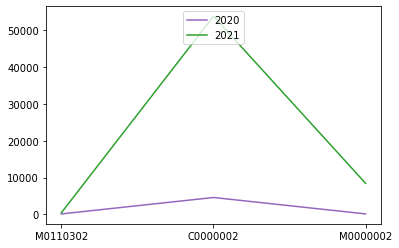

In [13]:
#Graficamos sin C000001
fig, ax = plt.subplots()

ejeY_noC1 = ejeY.drop(index=ejeY.index[0], axis=0)

ax.plot(ejeY_noC1['FLAG'], ejeY_noC1['Cantidad_20'], color = 'tab:purple', label="2020")
ax.plot(ejeY_noC1['FLAG'], ejeY_noC1['Cantidad_21'], color = 'tab:green', label="2021")
plt.legend(loc="upper center")
plt.show()

GRAFICO DE BARRAS DE LOS FLAGS


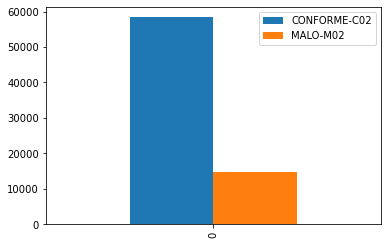

In [14]:
JoinDF = {}
#JoinDF['DUDOSO-D01'] = [ejeY[ejeY['FLAG'].str.startswith('D')].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
JoinDF['CONFORME-C02'] = [ejeY[ejeY['FLAG']=='C0000002'].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
JoinDF['MALO-M02'] = [ejeY[ejeY['FLAG'].str.startswith('M')].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
#JoinDF['CONFORME-T1'] = [ejeY[ejeY['FLAG']=='C0000001'].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
JoinDF = pd.DataFrame(JoinDF)

JoinDF.plot.bar()
print("GRAFICO DE BARRAS DE LOS FLAGS")

Precipitacion de datos con Flag M02


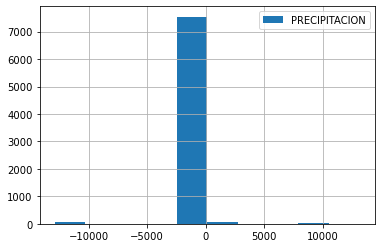

In [15]:
dfFlags21[dfFlags21['FLAG']=='M0000002']['PRECIPITACION'].hist(legend=True)
print('Precipitacion de datos con Flag M02')

Cantidad de datos M000001: 127


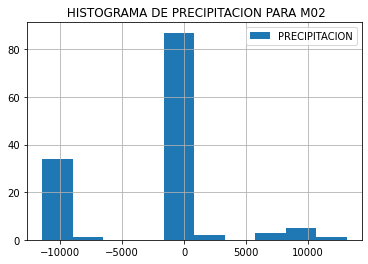

In [29]:
dfFlags20[dfFlags20['FLAG']=='M0000002']['PRECIPITACION'].hist(legend=True)
#print('Histograma precipitacion de datos con Flag M02')
print('Cantidad de datos M000001:', 92+35)
#print('Cantidad de datos M000001: ',dfFlags21[(dfFlags21['FLAG']=='M0000002') & (dfFlags21['PRECIPITACION']<0)]['PRECIPITACION'].count())
#print('Cantidad de datos mayor a 400: ',dfFlags21[(dfFlags21['FLAG']=='M0000002') & (dfFlags21['PRECIPITACION']>400)]['PRECIPITACION'].count())
plt.title(' HISTOGRAMA DE PRECIPITACION PARA M02')
plt.show()

Cantidad de datos M000001: 64
Histograma precipitacion de datos con Flag C02


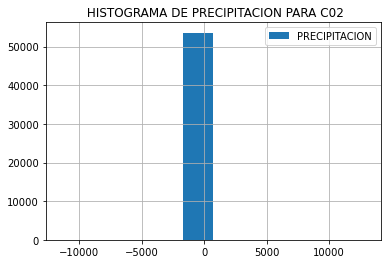

In [26]:
dfFlags21[dfFlags21['FLAG']=='C0000002']['PRECIPITACION'].hist(legend=True)

print('Cantidad de datos M000001:', 64)
#print('Cantidad de datos M000001: ',dfFlags21[(dfFlags21['FLAG']=='C0000002') & (dfFlags21['PRECIPITACION']<0)]['PRECIPITACION'].count())
#print('Cantidad de datos mayor a 400: ',dfFlags21[(dfFlags21['FLAG']=='C0000002') & (dfFlags21['PRECIPITACION']>400)]['PRECIPITACION'].count())
#print('Histograma precipitacion de datos con Flag C02')
plt.title(' HISTOGRAMA DE PRECIPITACION PARA C02')
plt.show()

Precipitacion de datos con Flag C02


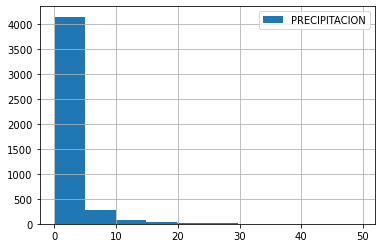

In [18]:
dfFlags20[dfFlags20['FLAG']=='C0000002']['PRECIPITACION'].hist(legend=True)
print('Precipitacion de datos con Flag C02')

In [28]:
dfFlags21[(dfFlags21['FLAG']=='C0000002') & (dfFlags21['PRECIPITACION']<0)]

,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG
29281,472A218A,ANTONIO RAIMONDI,09/04/2021,13:00:00,-11233.1,C0000002
76593,472501F4,BALSAS,03/12/2021,23:00:00,-3535.6,C0000002
137861,109096,BUENA VISTA,20/10/2021,22:00:00,-999.0,C0000002
146812,4727547C,CABALLOCOCHA,28/10/2021,21:00:00,-11080.1,C0000002
272767,113249,CAÑETE,13/10/2021,21:00:00,-999.0,C0000002
...,...,...,...,...,...,...
1842186,109091,SAUCEPAMPA,13/10/2021,22:00:00,-999.0,C0000002
1959818,47E2D1CC,TARATA,13/04/2021,23:00:00,-999.0,C0000002
2067309,472D60B4,USQUIL,07/11/2021,20:00:00,-4271.6,C0000002
2067525,472D60B4,USQUIL,16/11/2021,20:00:00,-999.0,C0000002


Histograma de precipitacion para el Flag C02 


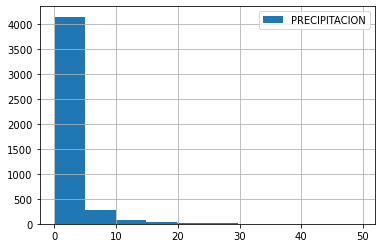

In [50]:
dfFlags20[dfFlags20['FLAG']=='C0000002']['PRECIPITACION'].hist(legend=True)
print("Histograma de precipitacion para el Flag C02 ")

In [111]:
#Realizaremos un resumen de los datos año 2021
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

resultados = resumenStats(path_base,Festaciones,Fdatos2021,'2021',grafico)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 36.67s


In [112]:
#Realizaremos un resumen de los datos año 2020
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

resultados = resumenStats(path_base,Festaciones,Fdatos2020,'2020',grafico)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 24.27s


In [122]:
#Realizaremos un resumen de los datos año 2020
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

resultados = resumenStats(path_base,Festaciones,Fdatos2020,'Total',grafico,listDir)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 57.51s
